In [329]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

# from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
# source https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [250]:
ls data/

sales_data.csv         store_item.csv         train.csv
sample_submission.csv  test.csv


In [251]:
store_item = pd.read_csv('data/store_item.csv')

In [252]:
store_item.head()

,date,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
0,2013-01-01,13,33,15,10,11,31,25,33,18,...,12,20,24,17,45,37,11,25,17,33
1,2013-01-02,11,43,30,11,6,36,23,37,23,...,10,22,29,10,45,33,13,24,13,37
2,2013-01-03,14,23,14,8,8,18,34,38,25,...,17,27,43,20,56,28,16,29,19,46
3,2013-01-04,13,18,10,19,9,19,36,54,22,...,13,24,27,12,50,44,11,39,23,51
4,2013-01-05,10,34,23,12,8,31,38,51,29,...,14,25,31,25,62,45,16,34,22,41


In [253]:
#set datatime to index
store_item['date'] = pd.to_datetime(store_item['date'])
store_item = store_item.set_index('date')

In [254]:
store_item.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [255]:
#split into train and valid sets
train_original = store_item.loc['2013-01-01':'2017-09-30']
valid_original  = store_item.loc['2017-10-01':'2017-12-31']

In [256]:
train_original.shape

(1734, 500)

In [257]:
df = store_item.copy()

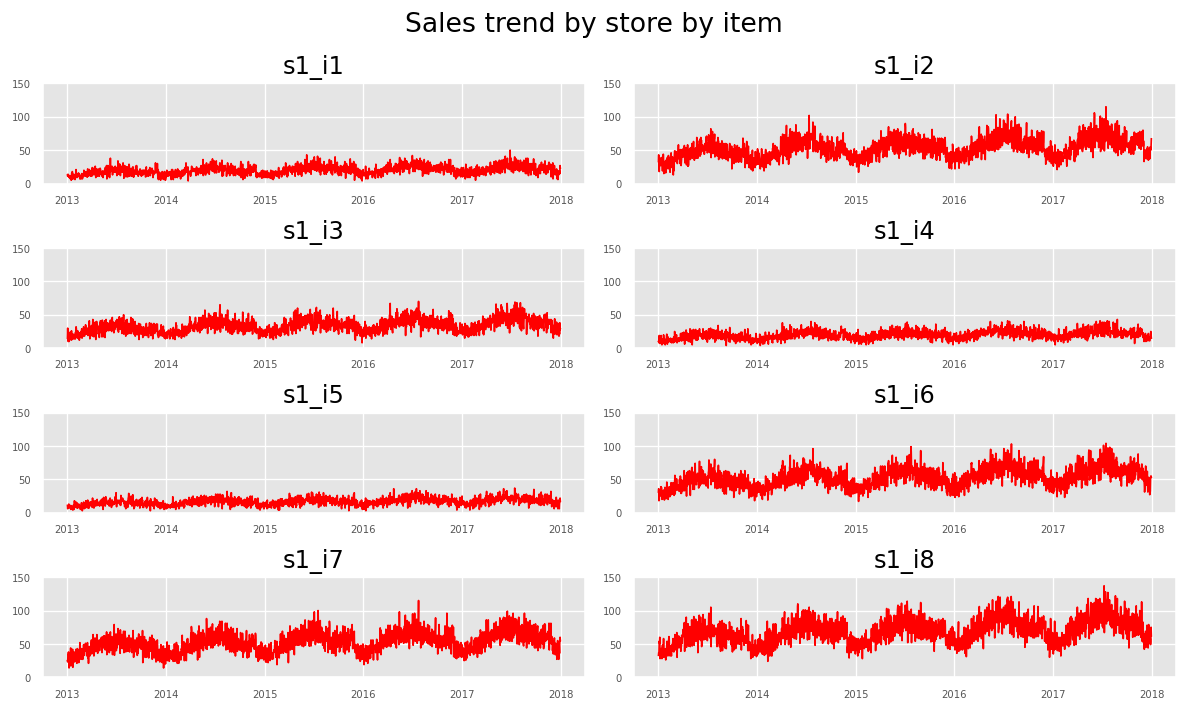

In [348]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_ylim(0,150)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
fig.suptitle("Sales trend by store by item", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88);
plt.savefig('images/Sales_trend_by_store_by_item.png')

#### Check for Stationarity and Make the Time Series Stationary

##### ADF Test

In [259]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [260]:
sampling = random.choices(np.arange(train_original.shape[1]), k=10)
sampling 

[152, 383, 188, 171, 19, 279, 382, 196, 462, 479]

In [261]:
df_train=train_original.iloc[:,sampling]
df_train.head()

,s4_i3,s8_i34,s4_i39,s4_i22,s1_i20,s6_i30,s8_i33,s4_i47,s10_i13,s10_i30
date,,,,,,,,,,
2013-01-01,17,16,18,44,22,25,49,23,46,21
2013-01-02,23,14,26,51,16,13,50,11,57,24
2013-01-03,27,21,27,47,24,16,39,11,36,29
2013-01-04,27,22,27,58,24,21,59,18,54,39
2013-01-05,19,19,22,55,36,20,59,18,55,30


In [262]:
# ADF Test on 10 columns
df_train=train_original.iloc[:]
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "s1_i1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9366
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0413. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s1_i2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8589
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0503. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "s1_i21" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6755
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0784. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i22" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5983
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0933. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i23" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s1_i44" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.905
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0448. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s1_i45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8613
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.05. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s1_i46" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

    Augmented Dickey-Fuller Test on "s2_i16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.762
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0639. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6931
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0752. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i18" 
    -----------------------------------------------
 Null Hypothesis: Data has 

    Augmented Dickey-Fuller Test on "s2_i36" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.77
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0627. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8465
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0519. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i38" 
    -----------------------------------------------
 Null Hypothesis: Data has u

    Augmented Dickey-Fuller Test on "s3_i10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9053
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0447. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s3_i11" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4907
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.1177. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s3_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s3_i29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7613
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.064. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s3_i30" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6838
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0769. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s3_i31" 
    -----------------------------------------------
 Null Hypothesis: Data has 

    Augmented Dickey-Fuller Test on "s3_i50" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9168
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0434. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s4_i1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7211
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0704. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

    Augmented Dickey-Fuller Test on "s4_i23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7649
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0635. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8119
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0566. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i25" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s4_i45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6353
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0859. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i46" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0729
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0286. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s4_i47" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s5_i16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9638
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0384. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s5_i17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7243
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0699. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s5_i18" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s5_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7148
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0715. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s5_i38" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0075
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0342. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s5_i39" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s6_i11" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6852
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0766. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7004
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.074. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i13" 
    -----------------------------------------------
 Null Hypothesis: Data has 

    Augmented Dickey-Fuller Test on "s6_i31" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7726
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0623. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i32" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8665
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0494. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s6_i33" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s7_i3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9495
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0399. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i4" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2995
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0149. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

    Augmented Dickey-Fuller Test on "s7_i27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1072
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.026. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i28" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7167
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0712. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s7_i29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

    Augmented Dickey-Fuller Test on "s7_i47" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0666
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0291. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i48" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9113
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.044. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i49" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

    Augmented Dickey-Fuller Test on "s8_i17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8918
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0463. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i18" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8102
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0568. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s8_i19" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s8_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6662
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0801. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s8_i38" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8557
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0507. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s8_i39" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s9_i11" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.016
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0334. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7455
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0665. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s9_i13" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

    Augmented Dickey-Fuller Test on "s9_i35" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1346
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0241. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i36" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7633
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0637. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s9_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s10_i8" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6502
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0831. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s10_i9" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8973
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0457. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s10_i10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

    Augmented Dickey-Fuller Test on "s10_i27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8846
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0472. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s10_i28" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7933
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0592. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s10_i29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

    Augmented Dickey-Fuller Test on "s10_i47" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.707
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0728. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s10_i48" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1193
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0252. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s10_i49" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

In [263]:
# 1st difference
differenced = train_original.diff().dropna()

In [264]:
differenced

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,-2.0,10.0,15.0,1.0,-5.0,5.0,-2.0,4.0,5.0,-3.0,...,-2.0,2.0,5.0,-7.0,0.0,-4.0,2.0,-1.0,-4.0,4.0
2013-01-03,3.0,-20.0,-16.0,-3.0,2.0,-18.0,11.0,1.0,2.0,-2.0,...,7.0,5.0,14.0,10.0,11.0,-5.0,3.0,5.0,6.0,9.0
2013-01-04,-1.0,-5.0,-4.0,11.0,1.0,1.0,2.0,16.0,-3.0,13.0,...,-4.0,-3.0,-16.0,-8.0,-6.0,16.0,-5.0,10.0,4.0,5.0
2013-01-05,-3.0,16.0,13.0,-7.0,-1.0,12.0,2.0,-3.0,7.0,-10.0,...,1.0,1.0,4.0,13.0,12.0,1.0,5.0,-5.0,-1.0,-10.0
2013-01-06,2.0,4.0,0.0,4.0,5.0,0.0,-6.0,9.0,6.0,19.0,...,-3.0,7.0,5.0,-6.0,2.0,5.0,1.0,13.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,4.0,12.0,12.0,0.0,1.0,4.0,-4.0,16.0,-2.0,22.0,...,-2.0,17.0,19.0,1.0,23.0,2.0,-2.0,16.0,-1.0,16.0
2017-09-27,9.0,-4.0,3.0,8.0,4.0,1.0,-1.0,-1.0,10.0,-12.0,...,1.0,-10.0,10.0,2.0,-6.0,11.0,7.0,-15.0,1.0,1.0
2017-09-28,-4.0,-2.0,-4.0,-10.0,2.0,-5.0,26.0,-22.0,-1.0,-2.0,...,13.0,13.0,2.0,1.0,4.0,-8.0,-7.0,9.0,0.0,2.0


#### Re-run ADF test on each differenced series.

In [265]:
df_differenced=differenced.iloc[:,sampling]

In [266]:
# ADF Test on each column of 1st Differences Dataframe

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "s4_i3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8583
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2852
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s4_i39" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

### Multivariate Forecast Model
#### Vector Autoregression (VAR)

In [267]:
# choice lag = 386

In [268]:
model_fitted = model.fit(365)

In [269]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

365


In [270]:
# Input data for forecasting
forecast_input = differenced.values[-lag_order:]
forecast_input

array([[  2.,   2.,  -5., ...,  -1.,  -1.,  18.],
       [  1.,  -5.,  10., ...,   7.,  -3.,   4.],
       [ -6., -25., -18., ..., -29.,  -1., -22.],
       ...,
       [ -4.,  -2.,  -4., ...,   9.,   0.,   2.],
       [  5.,  11.,  -2., ...,   5.,  -4.,   8.],
       [  2.,  13.,  13., ...,  -1.,  -2.,  13.]])

In [271]:
forecast_input.shape

(365, 500)

In [272]:
valid_original.shape

(92, 500)

In [273]:
fc = model_fitted.forecast(y=forecast_input, steps=92)
fc.shape

(92, 500)

In [274]:
df_forecast = pd.DataFrame(fc, index=valid_original.index, columns=df.columns + '_1d')
df_forecast

,s1_i1_1d,s1_i2_1d,s1_i3_1d,s1_i4_1d,s1_i5_1d,s1_i6_1d,s1_i7_1d,s1_i8_1d,s1_i9_1d,s1_i10_1d,...,s10_i41_1d,s10_i42_1d,s10_i43_1d,s10_i44_1d,s10_i45_1d,s10_i46_1d,s10_i47_1d,s10_i48_1d,s10_i49_1d,s10_i50_1d
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,-1.701083,-6.143321,-0.643015,4.003380,2.890530,5.661241,-9.902416,5.244278,-2.594031,12.896117,...,0.605511,16.638627,3.811497,2.687025,11.634494,-5.679120,-1.030150,7.940018,13.015547,-1.535390
2017-10-02,-10.817533,-27.001452,-17.185234,-8.930922,-8.466089,-26.627363,-24.186088,-30.491102,-20.717280,-32.232516,...,-12.398276,-19.099715,-26.396783,-14.879350,-40.857622,-29.624555,-11.061535,-29.144646,-15.831981,-35.602006
2017-10-03,3.973955,8.396112,4.693019,2.276673,2.067192,9.695309,7.926552,9.229565,5.528175,11.993992,...,4.290650,4.204422,7.939190,3.809124,12.513427,10.337646,3.962498,6.724723,4.945528,10.077645
2017-10-04,1.230544,1.792950,0.528434,0.414693,1.850761,2.193768,-1.494784,-2.993325,2.893399,0.505613,...,0.708669,0.082690,0.602198,-1.399991,-0.771360,0.897957,-0.683321,2.894604,2.370574,1.025369
2017-10-05,-0.605748,1.385322,1.153636,0.982830,1.313603,1.329974,4.652122,4.141914,3.911523,4.453417,...,2.400597,2.360603,0.389577,0.114643,6.802754,1.774276,2.326173,3.699904,0.763474,4.617184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1.049874,0.105122,0.709703,-0.055608,0.093627,-0.725573,0.368895,1.300924,0.289449,-0.675187,...,-0.080669,-0.616664,2.792552,-0.500119,4.722305,-2.748988,-0.631635,-0.339085,2.033832,0.705303
2017-12-28,0.294652,2.058298,0.608175,1.157019,0.735647,1.310495,1.112054,0.897453,1.877736,4.839246,...,0.559869,1.026562,0.280967,1.042074,0.568266,4.528396,2.390312,1.895721,-1.265379,5.055328
2017-12-29,2.217322,1.962241,1.910305,0.269057,-0.167026,2.960274,2.372649,1.574031,0.971925,1.822637,...,-0.455335,2.095527,2.000819,1.757482,3.633185,4.214011,0.755817,1.291484,2.142548,2.598197


#### Invert the transformation to get the real forecast

In [275]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    
    df_fc = df_fc.iloc[:,df_train.shape[1]:]
    return df_fc

In [276]:
df_results = invert_transformation(train_original, df_forecast, second_diff=False)        


In [277]:
df_results.shape

(92, 500)

In [278]:
df_results

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,28.298917,72.856679,47.356985,26.003380,21.890530,69.661241,70.097584,95.244278,61.405969,86.896117,...,33.605511,56.638627,79.811497,44.687025,119.634494,87.320880,32.969850,77.940018,44.015547,101.464610
2017-10-02,17.481383,45.855226,30.171751,17.072458,13.424441,43.033878,45.911496,64.753175,40.688689,54.663601,...,21.207235,37.538912,53.414714,29.807675,78.776872,57.696325,21.908315,48.795373,28.183566,65.862604
2017-10-03,21.455338,54.251338,34.864771,19.349130,15.491632,52.729187,53.838048,73.982740,46.216864,66.657594,...,25.497885,41.743334,61.353904,33.616799,91.290299,68.033972,25.870813,55.520095,33.129094,75.940249
2017-10-04,22.685883,56.044288,35.393204,19.763823,17.342394,54.922954,52.343265,70.989415,49.110263,67.163207,...,26.206554,41.826024,61.956102,32.216808,90.518939,68.931929,25.187492,58.414700,35.499668,76.965618
2017-10-05,22.080135,57.429610,36.546841,20.746653,18.655997,56.252928,56.995386,75.131329,53.021786,71.616624,...,28.607151,44.186628,62.345679,32.331451,97.321693,70.706204,27.513665,62.114604,36.263142,81.582802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,15.517599,43.387061,26.111563,15.260324,13.870246,44.218889,42.282628,57.373110,36.543536,51.729792,...,20.550360,32.645848,48.916504,25.874763,74.720639,51.683870,19.483391,47.281117,29.627659,57.181583
2017-12-28,15.812252,45.445359,26.719738,16.417343,14.605893,45.529384,43.394682,58.270563,38.421272,56.569038,...,21.110229,33.672411,49.197471,26.916837,75.288905,56.212265,21.873703,49.176839,28.362280,62.236911
2017-12-29,18.029574,47.407600,28.630043,16.686400,14.438867,48.489659,45.767331,59.844593,39.393197,58.391675,...,20.654894,35.767938,51.198290,28.674319,78.922090,60.426277,22.629520,50.468322,30.504829,64.835108


In [279]:
df_results.columns[0],df_results.columns[499]

('s1_i1_forecast', 's10_i50_forecast')

In [280]:
random.randint(1,500)

348

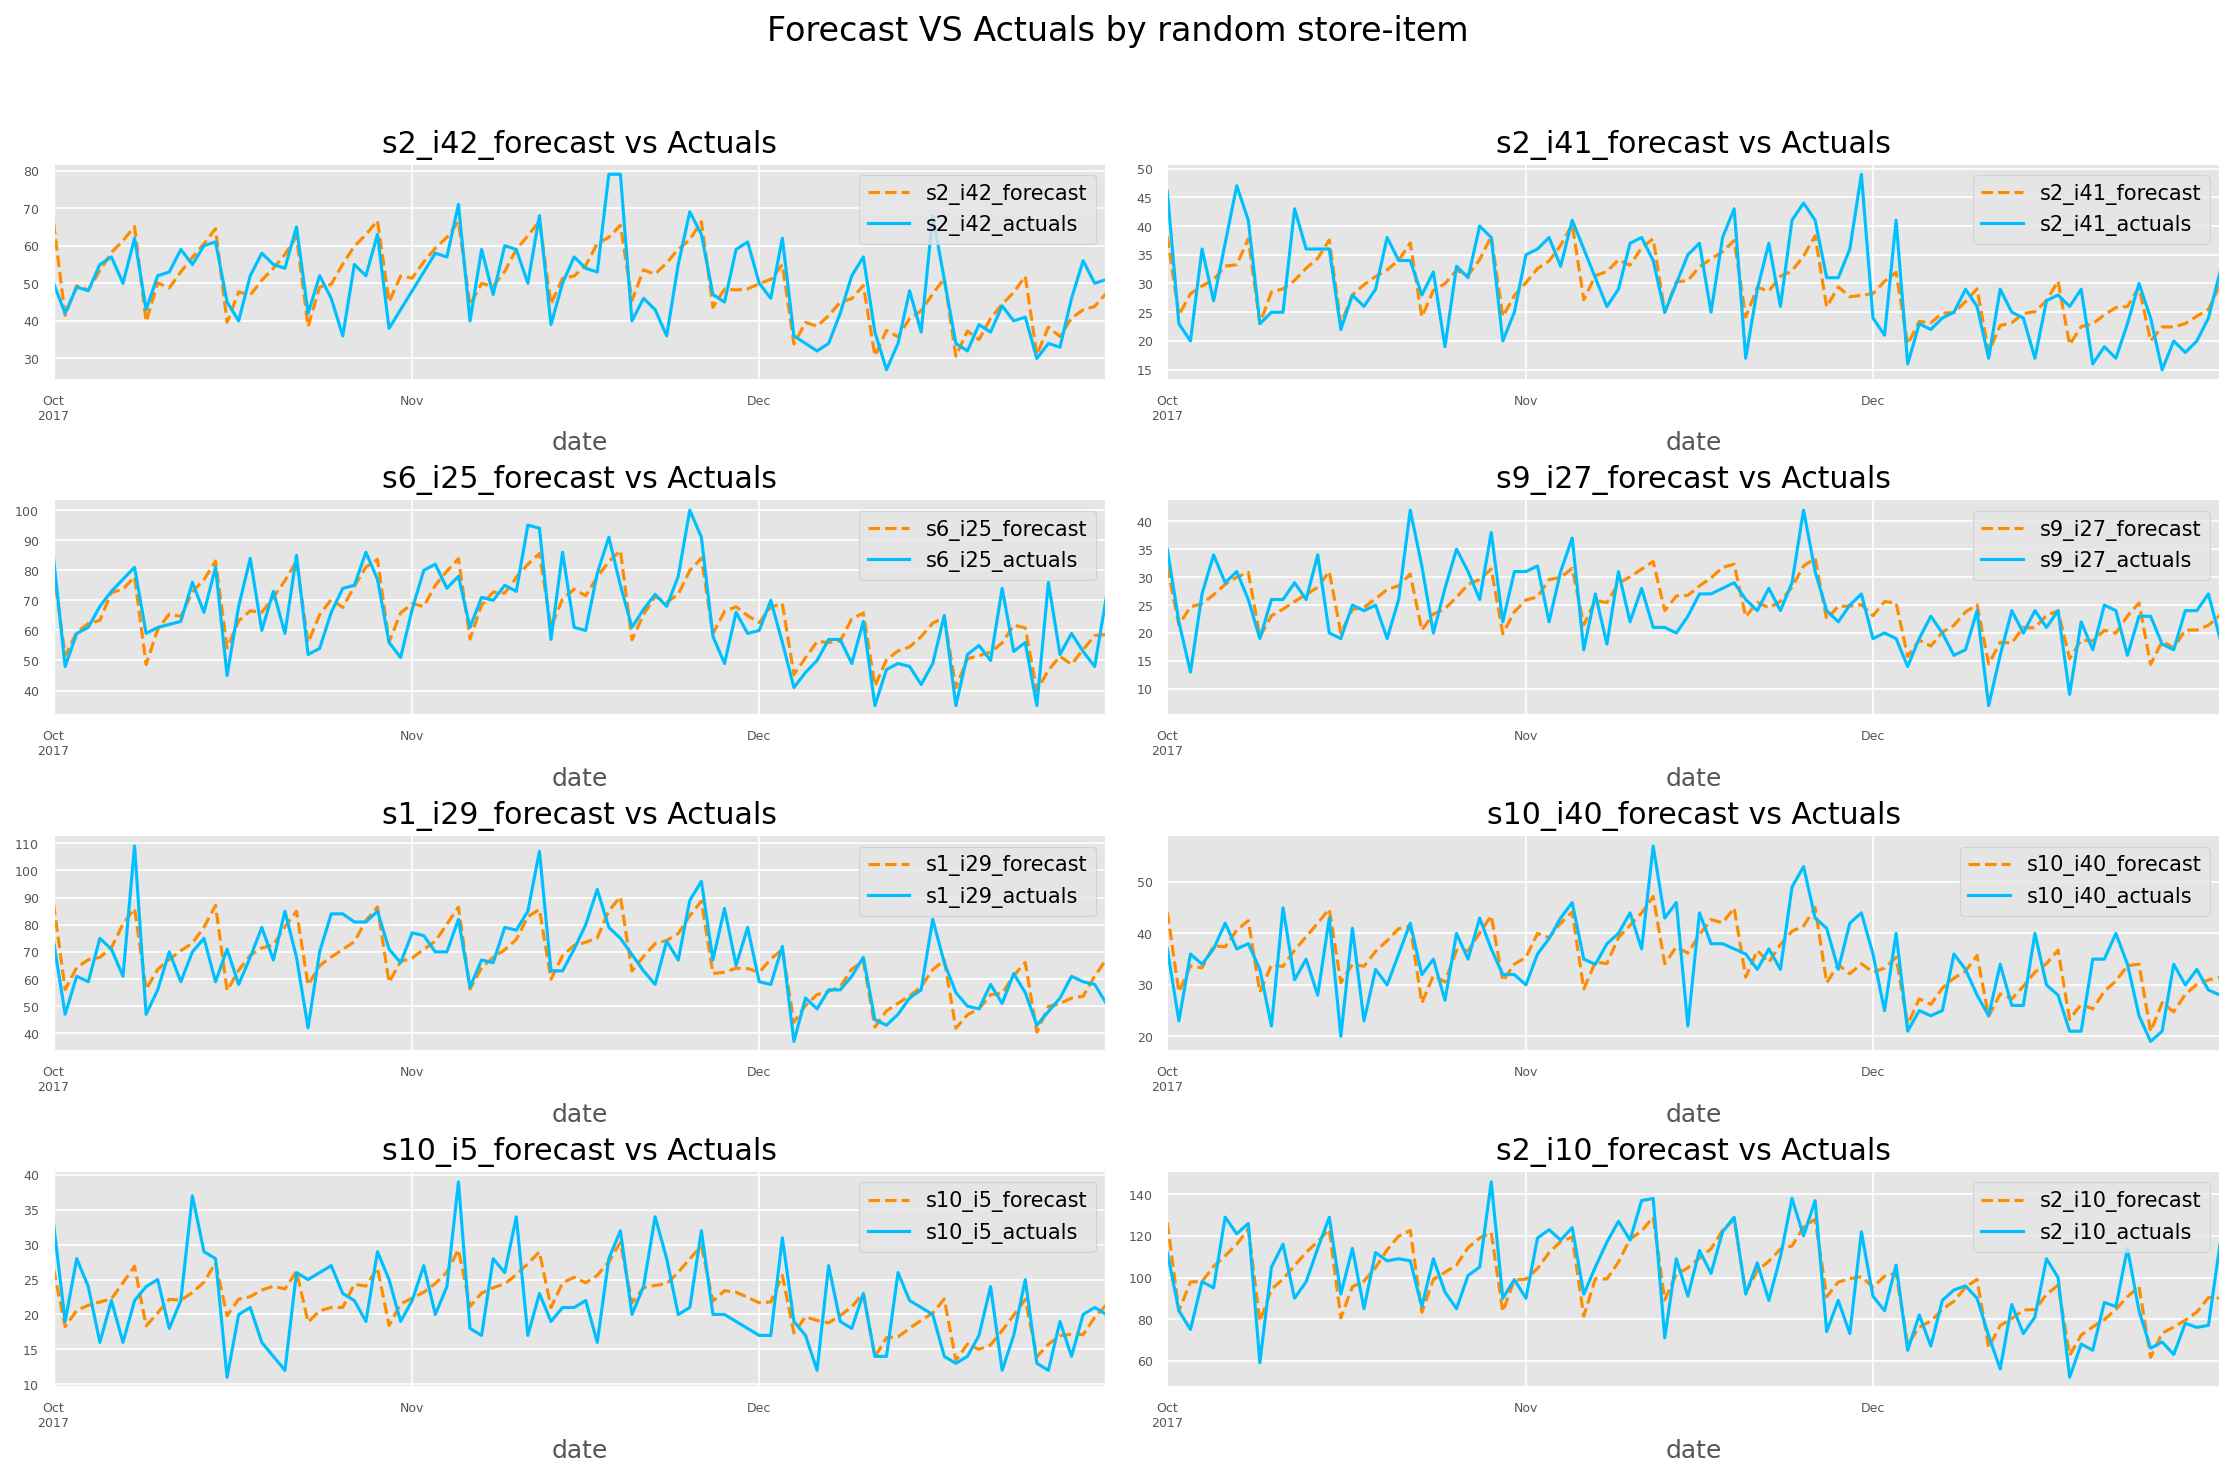

In [349]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=150, figsize=(15,10))
for i, ax in enumerate( axes.flatten()):
    col = random.randint(1,valid_original.shape[1])
    df_results[df_results.columns[col]].plot(legend=True, ax=ax,linestyle='--',color='darkorange').autoscale(axis='x',tight=True)
    valid_original[valid_original.columns[col]].plot(legend=True, ax=ax, label=valid_original.columns[col]+'_actuals',color='deepskyblue');
    ax.set_title( f'{df_results.columns[col]} vs Actuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle("Forecast VS Actuals by random store-item", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88);
plt.savefig('images/Forecast_VS_Actuals_by_random_store-item.png')

In [282]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and the lower Mean Square Error always reflects the better results 
def rmse_calculate(valid,forefast):
    columns = valid.columns.tolist()
    rmses=np.zeros(len(columns))
    means=np.zeros(len(columns))
    stds = np.zeros(len(columns))
    for i, col in enumerate( columns):
        mse = ((valid[col] - forefast[str(col)+'_forecast']) ** 2).mean()
        rmse = np.sqrt(mse)
        mean = valid[col].mean()
        std  = valid[col].std()
        rmses[i]=rmse
        means[i] = valid[col].mean()
        stds[i] = std
    df_rmses = pd.DataFrame({'observed_mean':means, 'rmses':rmses,'one_std':stds
                            },index =columns)
                        
    return df_rmses

In [283]:
df_rmses = rmse_calculate(valid_original,df_results)

In [284]:
df_rmses["store_item"]=df_rmses.index.tolist()
df_rmses

,observed_mean,rmses,one_std,store_item
s1_i1,20.228261,4.786380,5.855594,s1_i1
s1_i2,56.358696,7.776052,11.081696,s1_i2
s1_i3,34.010870,6.072510,8.044512,s1_i3
s1_i4,20.413043,4.551083,5.600534,s1_i4
s1_i5,17.130435,4.194145,5.386629,s1_i5
...,...,...,...,...
s10_i46,68.163043,9.711136,16.286769,s10_i46
s10_i47,25.663043,5.583483,6.789256,s10_i47
s10_i48,60.760870,8.224922,13.678707,s10_i48
s10_i49,33.086957,6.457852,9.121466,s10_i49


In [285]:
df_plot =df_rmses[:10]

In [286]:
df_plot

,observed_mean,rmses,one_std,store_item
s1_i1,20.228261,4.786380,5.855594,s1_i1
s1_i2,56.358696,7.776052,11.081696,s1_i2
s1_i3,34.010870,6.072510,8.044512,s1_i3
s1_i4,20.413043,4.551083,5.600534,s1_i4
s1_i5,17.130435,4.194145,5.386629,s1_i5
s1_i6,56.282609,8.242218,12.048734,s1_i6
s1_i7,55.076087,7.713632,12.443484,s1_i7
s1_i8,72.913043,9.519018,15.919890,s1_i8
s1_i9,47.032609,7.701568,11.068668,s1_i9
s1_i10,70.130435,9.916310,15.703445,s1_i10


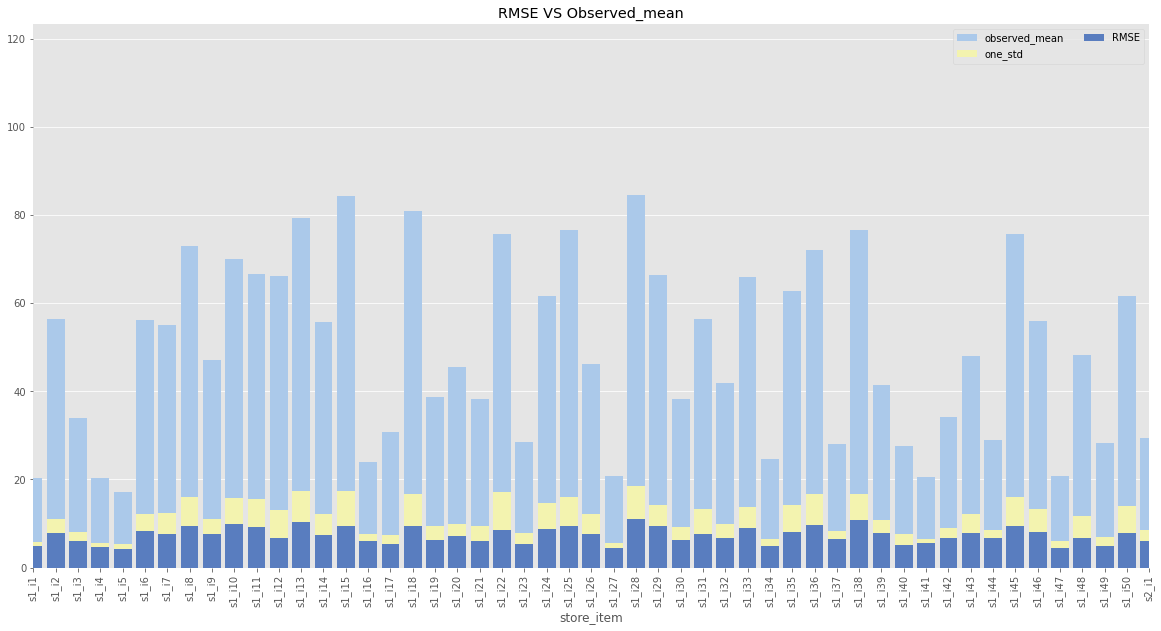

In [288]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")

sns.barplot(y="observed_mean", x="store_item", data=df_rmses,
            label="observed_mean", color="b")
sns.barplot(y="one_std",x="store_item",data=df_rmses,
            label="one_std", color="y")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y="rmses",x="store_item",data=df_rmses,
            label="RMSE", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 50), ylabel="",
       xlabel="store_item")
ax.set_title('RMSE VS Observed_mean')
ax.set_xticklabels(labels = df_rmses.index,rotation=90)
sns.despine(left=True, bottom=True)
plt.savefig('images/VAR_observed_mean_VS_rmse.png')

In [338]:
row_random_lst =random.choices(np.arange(df_rmses.shape[0]), k=16)
print("row_random_lst: ",row_random_lst)
store_item_random = df_rmses.iloc[row_random_lst]
store_item_random

row_random_lst:  [339, 107, 16, 280, 349, 0, 436, 13, 333, 323, 26, 13, 214, 491, 331, 435]


,observed_mean,rmses,one_std,store_item
s7_i40,21.641304,4.660029,5.986398,s7_i40
s3_i8,91.586957,9.858712,19.301627,s3_i8
s1_i17,30.847826,5.285895,7.499355,s1_i17
s6_i31,45.967391,6.786455,10.729902,s6_i31
s7_i50,47.923913,6.960277,11.692238,s7_i50
s1_i1,20.228261,4.786380,5.855594,s1_i1
s9_i37,33.543478,6.979993,9.158450,s9_i37
s1_i14,55.684783,7.463700,12.089346,s1_i14
s7_i34,18.315217,4.096386,5.481095,s7_i34
s7_i24,48.315217,7.573852,10.613002,s7_i24


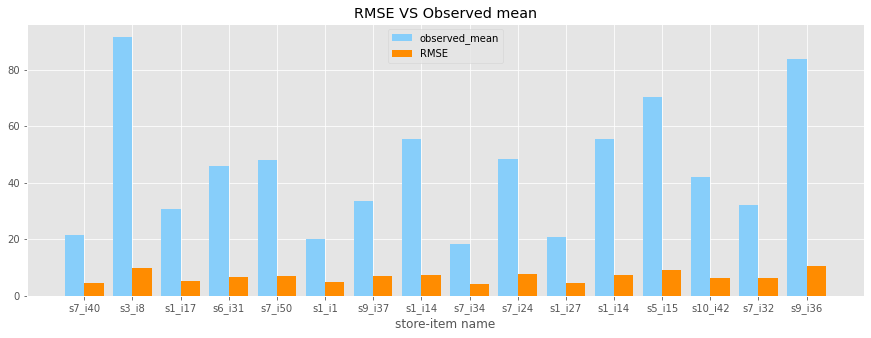

In [339]:
# Numbers of pairs of bars you want
N = store_item_random.shape[0]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,5))

# Width of a bar 
width = 0.4       

# Plotting
plt.bar(ind, store_item_random.observed_mean , width, label='observed_mean',color='lightskyblue')
plt.bar(ind + width, store_item_random.rmses, width, label='RMSE',color='darkorange')


plt.xlabel('store-item name')
plt.title('RMSE VS Observed mean')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, store_item_random.store_item)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()